<a href="https://colab.research.google.com/github/sarnavadatta/Finance-in-Python/blob/main/MC_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Monte Carlo Simulation with Cholesky Decomposition for Correlated Stock Prices

## 🧮 1. Multivariate Normal Distribution for Log Returns

In financial modeling, the continuously compounded (log) returns of multiple assets are assumed to follow a **Multivariate Normal Distribution**:

$$
\mathbf{r} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Where:
- $ \mathbf{r} \in \mathbb{R}^n $ is the vector of log returns
- $ \boldsymbol{\mu} \in \mathbb{R}^n $ is the mean return vector
- $ \boldsymbol{\Sigma} \in \mathbb{R}^{n \times n} $ is the **covariance matrix** of returns

Each asset $ r_i $ is normally distributed, but not independent — their correlations are encoded in $ \boldsymbol{\Sigma} $.

---

## 🔻 2. Cholesky Decomposition

To simulate correlated normal random variables, we apply the **Cholesky decomposition** to the covariance matrix:

$$
\boldsymbol{\Sigma} = \mathbf{L} \mathbf{L}^\top
$$

Where:
- $ \mathbf{L} $ is a **lower triangular matrix** (Cholesky factor)

Then, for $ \mathbf{Z} \sim \mathcal{N}(0, \mathbf{I}_n) $ (independent standard normals):

$$
\mathbf{r} = \boldsymbol{\mu} \cdot \Delta t + \mathbf{L} \cdot \mathbf{Z} \cdot \sqrt{\Delta t}
$$

This gives simulated log returns with the correct mean and covariance structure.

---

## 📈 3. Monte Carlo Simulation of Stock Prices

We assume that each asset follows **Geometric Brownian Motion (GBM)**:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

The solution is:

$$
S_t = S_0 \cdot \exp\left( \left( \mu - \frac{1}{2} \sigma^2 \right) t + \sigma W_t \right)
$$

For the **discrete-time, multivariate case**, we simulate:

$$
\mathbf{S}_{t+\Delta t} = \mathbf{S}_t \circ \exp\left( \mathbf{r}_t \right)
$$

Where:
- $ \mathbf{r}_t $ is the correlated log return vector from above
- $ \circ $ denotes element-wise multiplication

Repeat this process over time to simulate full price paths for multiple assets.

---

## 🧠 Summary

1. Use historical returns to estimate $ \boldsymbol{\mu} $ and $ \boldsymbol{\Sigma} $
2. Perform **Cholesky decomposition**: $ \boldsymbol{\Sigma} = \mathbf{L} \mathbf{L}^\top $
3. Generate i.i.d. normal samples $ \mathbf{Z} \sim \mathcal{N}(0, \mathbf{I}) $
4. Construct correlated log returns:  
   $$
   \mathbf{r}_t = \boldsymbol{\mu} \cdot \Delta t + \mathbf{L} \cdot \mathbf{Z}_t \cdot \sqrt{\Delta t}
   $$
5. Update prices:  
   $$
   \mathbf{S}_{t+1} = \mathbf{S}_t \circ \exp(\mathbf{r}_t)
   $$

This framework supports advanced portfolio risk analysis, Value at Risk (VaR), and correlated multi-asset forecasting.



In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Download Data
tickers = ['TATAMOTORS.NS', 'HDFCBANK.NS', 'INFY.NS']
data = yf.download(tickers, start='2020-01-01', end='2025-07-02')['Close']
log_returns = np.log(data / data.shift(1)).dropna()

/tmp/ipython-input-2-3691136530.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2020-01-01', end='2025-07-02')['Close']
[*********************100%***********************]  3 of 3 completed


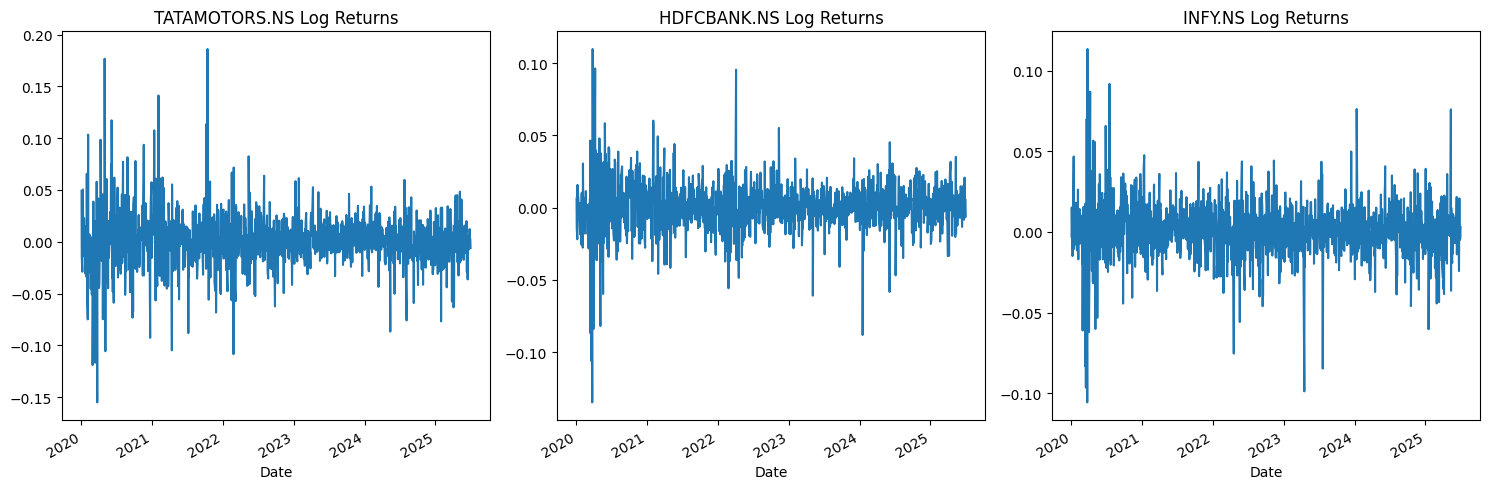

In [ ]:
# Plot the log returns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

log_returns['TATAMOTORS.NS'].plot(ax=axes[0], title='TATAMOTORS.NS Log Returns')
log_returns['HDFCBANK.NS'].plot(ax=axes[1], title='HDFCBANK.NS Log Returns')
log_returns['INFY.NS'].plot(ax=axes[2], title='INFY.NS Log Returns')

plt.tight_layout()
plt.show()

##  Estimate Mean and Covariance

Let $ \boldsymbol{\mu} $ be the vector of mean log returns and $ \boldsymbol{\Sigma} $ the covariance matrix:

$$
\boldsymbol{\mu} = \mathbb{E}[\mathbf{r}], \quad \boldsymbol{\Sigma} = \text{Cov}(\mathbf{r})
$$

## Cholesky Decomposition

We use Cholesky to decompose the covariance matrix $ \boldsymbol{\Sigma} $ into:

$$
\boldsymbol{\Sigma} = \mathbf{L} \mathbf{L}^\top
$$

This allows us to convert independent standard normals into correlated samples.

In [ ]:
# Estimate parameters
mu = log_returns.mean().values         # Expected return vector
cov = log_returns.cov().values         # Covariance matrix
L = np.linalg.cholesky(cov)            # Cholesky decomposition

In [ ]:
# Simulation parameters
n_assets = len(tickers)
T = 1
N = 252
dt = T / N
M = 1000  # simulations
S0 = data.iloc[-1].values              # Current prices

In [ ]:
# Step 4: Simulate correlated paths
np.random.seed(42)
simulated_paths = np.zeros((N, M, n_assets))
simulated_paths[0] = S0

In [ ]:
for t in range(1, N):
    Z = np.random.standard_normal((M, n_assets))  # Independent normals
    correlated_Z = Z @ L.T                        # Introduce correlation
    drift = (mu - 0.5 * np.diag(cov)) * dt
    diffusion = correlated_Z * np.sqrt(dt)
    log_returns_t = drift + diffusion
    simulated_paths[t] = simulated_paths[t-1] * np.exp(log_returns_t)

## Monte Carlo Simulation Using GBM

We simulate future asset prices using the multivariate Geometric Brownian Motion:

$
\mathbf{r}_t = \boldsymbol{\mu} \cdot \Delta t + \mathbf{L} \cdot \mathbf{Z}_t \cdot \sqrt{\Delta t}
$

$
\mathbf{S}_{t+1} = \mathbf{S}_t \circ \exp(\mathbf{r}_t)
$


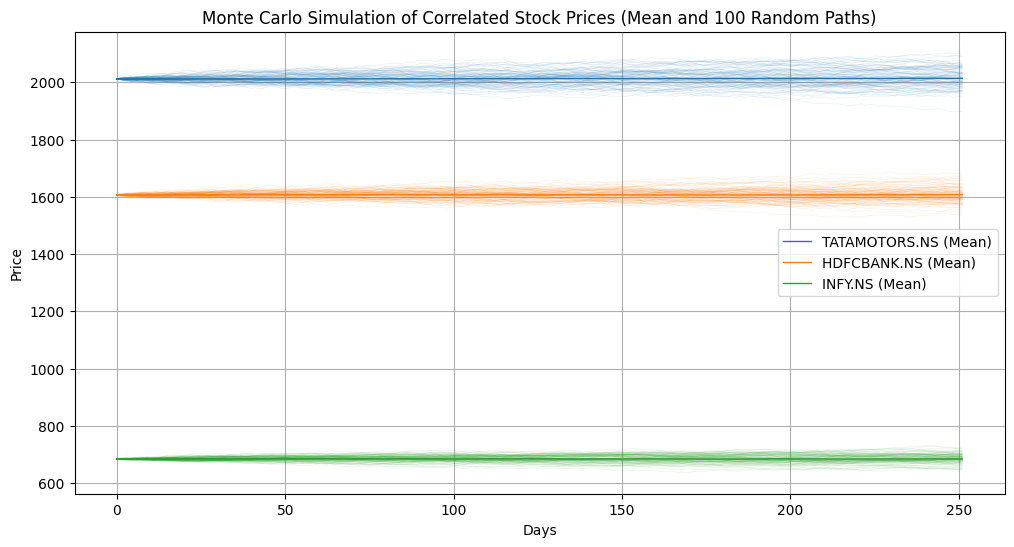

In [ ]:
# Plot only one graph showing the mean and 100 random simulated path for all three stock.

plt.figure(figsize=(12, 6))

# Plot mean path for each stock
for i in range(n_assets):
  plt.plot(simulated_paths[:, :, i].mean(axis=1), label=f'{tickers[i]} (Mean)', linewidth=1)

# Plot 100 random paths for each stock
num_random_paths = 100
for i in range(n_assets):
  for j in range(num_random_paths):
    plt.plot(simulated_paths[:, j, i], alpha=0.1, linewidth=0.5, color=f'C{i}') # Use same color as mean, with transparency

plt.title("Monte Carlo Simulation of Correlated Stock Prices (Mean and 100 Random Paths)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Portfolio Value at Risk (VaR)

We define portfolio weights $\mathbf{w}$, and calculate:

$
\text{Portfolio Value}_T^{(i)} = \mathbf{S}_T^{(i)} \cdot \mathbf{w}
$

$
\text{VaR}_{\alpha} = \text{Initial Value} - \text{Quantile}_{\alpha}(\text{Portfolio Values})
$


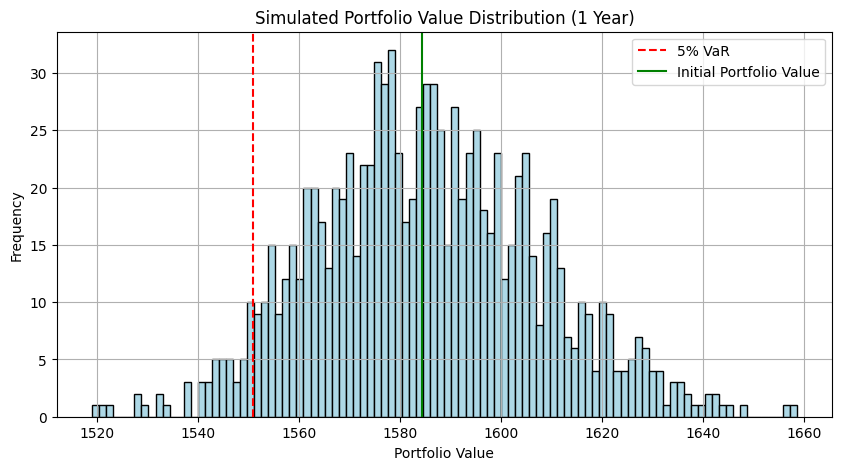

Initial Portfolio Value: ₹1584.32
Portfolio VaR (95%, 1 year): ₹33.29


In [ ]:
# Define portfolio weights (sum to 1)
weights = np.array([0.4, 0.4, 0.2])  # 40% Tata, 40% HDFC, 20% INFY

# Compute portfolio value at time 0
initial_portfolio_value = np.dot(S0, weights)

# Get final simulated prices (at time T)
final_prices = simulated_paths[-1]  # shape: (M, n_assets)

# Compute portfolio values across simulations
final_portfolio_values = final_prices @ weights

# Calculate Portfolio VaR (95% confidence level)
confidence_level = 0.95
VaR_95 = initial_portfolio_value - np.percentile(final_portfolio_values, (1 - confidence_level) * 100)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(final_portfolio_values, bins=100, color='lightblue', edgecolor='black')
plt.axvline(np.percentile(final_portfolio_values, 5), color='red', linestyle='--', label='5% VaR')
plt.axvline(initial_portfolio_value, color='green', linestyle='-', label='Initial Portfolio Value')
plt.title("Simulated Portfolio Value Distribution (1 Year)")
plt.xlabel("Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Output results
print(f"Initial Portfolio Value: ₹{initial_portfolio_value:.2f}")
print(f"Portfolio VaR (95%, 1 year): ₹{VaR_95:.2f}")

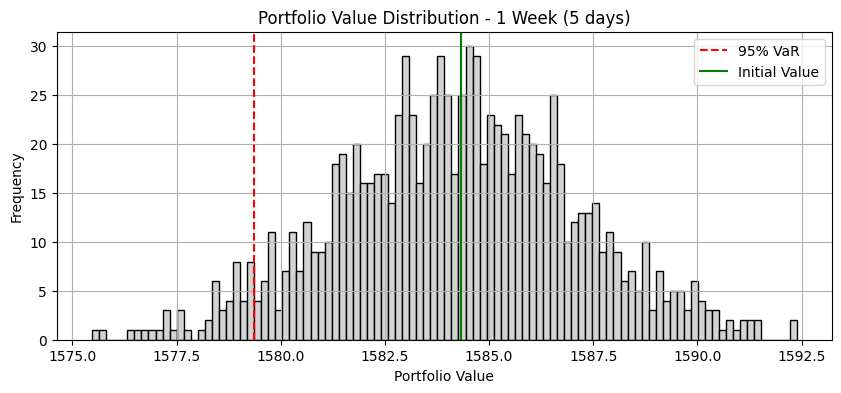

--- 1 Week (5 days) ---
Expected Portfolio Value: ₹1584.22
95% Confidence Interval: [₹1578.56, ₹1589.89]
VaR (95%): ₹4.96



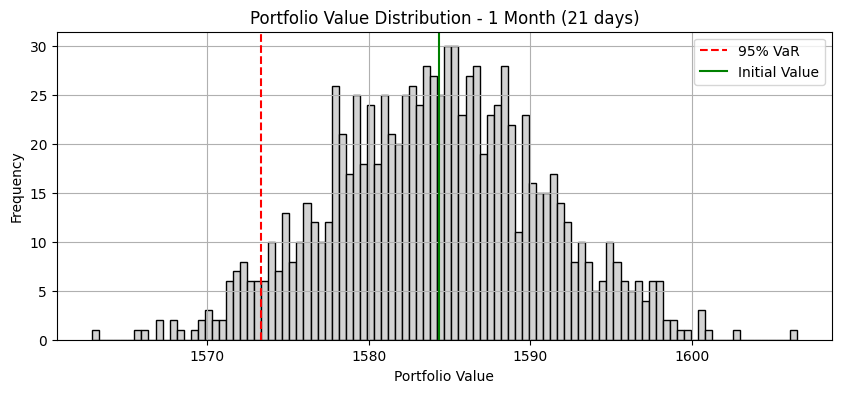

--- 1 Month (21 days) ---
Expected Portfolio Value: ₹1584.20
95% Confidence Interval: [₹1571.77, ₹1597.02]
VaR (95%): ₹11.00



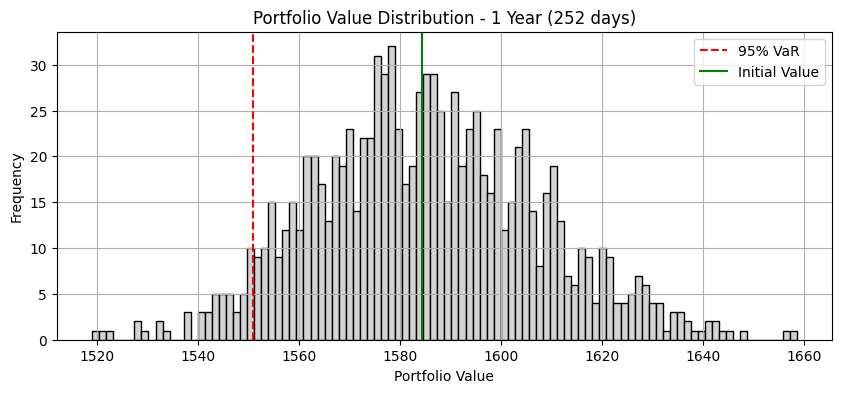

--- 1 Year (252 days) ---
Expected Portfolio Value: ₹1585.31
95% Confidence Interval: [₹1544.88, ₹1630.26]
VaR (95%): ₹33.29



In [ ]:
# --- Portfolio Settings ---
weights = np.array([0.4, 0.4, 0.2])
initial_portfolio_value = np.dot(S0, weights)
confidence_level = 0.95
alpha = 1 - confidence_level

def compute_var(sim_paths, day_idx, label):
    prices = sim_paths[day_idx]            # Prices at horizon
    portfolio_vals = prices @ weights      # Final values
    var = initial_portfolio_value - np.percentile(portfolio_vals, alpha * 100)
    mean_val = np.mean(portfolio_vals)
    ci_low, ci_high = np.percentile(portfolio_vals, [2.5, 97.5])

    # Plot
    plt.figure(figsize=(10, 4))
    plt.hist(portfolio_vals, bins=100, color='lightgray', edgecolor='black')
    plt.axvline(np.percentile(portfolio_vals, alpha * 100), color='red', linestyle='--', label=f'{int(confidence_level*100)}% VaR')
    plt.axvline(initial_portfolio_value, color='green', linestyle='-', label='Initial Value')
    plt.title(f"Portfolio Value Distribution - {label}")
    plt.xlabel("Portfolio Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"--- {label} ---")
    print(f"Expected Portfolio Value: ₹{mean_val:.2f}")
    print(f"95% Confidence Interval: [₹{ci_low:.2f}, ₹{ci_high:.2f}]")
    print(f"VaR (95%): ₹{var:.2f}\n")
    return var

# --- Compute VaR for Different Horizons ---
VaR_1w = compute_var(simulated_paths, day_idx=4, label="1 Week (5 days)")
VaR_1m = compute_var(simulated_paths, day_idx=20, label="1 Month (21 days)")
VaR_1y = compute_var(simulated_paths, day_idx=251, label="1 Year (252 days)")
